In [ ]:
import torch
import numpy as np
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define parameters
num_classes = 10
noise_rate = 0.4  # Set noise rate η ∈ [0.2, 0.8]

# dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# symmetric noise in labels
def add_symmetric_noise(labels, noise_rate, num_classes):

    labels = np.array(labels)  # Ensure it's a NumPy array
    noisy_labels = labels.copy()  # Create a copy to avoid modifying the original array
    num_noisy = int(noise_rate * len(labels))  # Number of labels to corrupt
    noisy_indices = np.random.choice(len(labels), num_noisy, replace=False)  # Select random indices

    for i in noisy_indices:
        original_label = labels[i]
        possible_labels = np.delete(np.arange(num_classes), original_label)  # Remove the correct label
        new_label = np.random.choice(possible_labels)  # Pick a random incorrect label
        noisy_labels[i] = int(new_label)  # Ensure it's an integer

    return noisy_labels



100%|██████████| 170M/170M [00:04<00:00, 40.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
original_labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 10)  # 100 labels (balanced dataset)
noisy_labels = add_symmetric_noise(original_labels, noise_rate=0.2, num_classes=10)

# Checking how many labels were modified
num_changed = (original_labels != noisy_labels).sum()
print(f"Original Labels: {original_labels[:20]}")
print(f"Noisy Labels: {noisy_labels[:20]}")
print(f"Total modified: {num_changed}/{len(original_labels)}")


Original Labels: [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
Noisy Labels: [7 1 2 3 7 5 6 7 8 9 9 1 3 3 4 5 6 7 9 9]
Total modified: 20/100


In [ ]:
# Apply noise to training labels
train_labels = np.array(train_dataset.targets)  # Get original labels
train_dataset.targets = add_symmetric_noise(train_labels, noise_rate, num_classes)  # Apply noise

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print sample of noisy labels for verification
print("Sample noisy labels:", train_dataset.targets[:10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Sample noisy labels: [1 7 9 4 5 1 1 1 8 3]


In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Check for GPU

# Define a Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Standard Cross-Entropy Loss
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        return self.ce_loss(outputs, targets)

# Standard Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, outputs, targets):
        ce_loss = self.ce_loss(outputs, targets)
        pt = torch.exp(-ce_loss)  # Probability of correct class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

class NormalizedCrossEntropyLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(NormalizedCrossEntropyLoss, self).__init__()
        self.epsilon = epsilon  # To avoid division by zero

    def forward(self, outputs, targets):

        # Convert labels to one-hot
        q = F.one_hot(targets, num_classes=outputs.shape[1]).float()
        p = F.softmax(outputs, dim=1)  # Convert logits to probabilities

        # Compute standard cross-entropy loss
        ce_loss = -torch.sum(q * torch.log(p + self.epsilon), dim=1)  # [batch_size]

        # Compute normalization factor
        denom = -torch.sum(q.unsqueeze(1) * torch.log(p + self.epsilon), dim=(1, 2))  # [batch_size]

        # Compute final normalized loss
        nce_loss = ce_loss / (denom + self.epsilon)
        return nce_loss.mean()

class NormalizedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, epsilon=1e-6):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, outputs, targets):

        # Convert labels to one-hot
        q = F.one_hot(targets, num_classes=outputs.shape[1]).float()
        p = F.softmax(outputs, dim=1)  # Convert logits to probabilities

        # Compute standard focal loss term
        focal_term = (1 - p) ** self.gamma
        focal_loss = -torch.sum(q * focal_term * torch.log(p + self.epsilon), dim=1)  # [batch_size]

        # Compute normalization factor
        denom = -torch.sum(q.unsqueeze(1) * focal_term.unsqueeze(1) * torch.log(p + self.epsilon), dim=(1, 2))  # [batch_size]

        # Compute final normalized focal loss
        nfl_loss = focal_loss / (denom + self.epsilon)
        return nfl_loss.mean()
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    history = {'train_loss': [], 'train_acc': []}

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.4f}")

    return history



In [ ]:
# Train with Standard Cross-Entropy Loss
ce_model = SimpleCNN().to(device)
ce_criterion = CrossEntropyLoss().to(device)
ce_optimizer = optim.Adam(ce_model.parameters(), lr=0.001)

print("\nTraining with Cross-Entropy Loss...")
ce_history = train_model(ce_model, train_loader, ce_criterion, ce_optimizer, epochs=10)

# Save results
torch.save(ce_history, "ce_history.pth")



Training with Cross-Entropy Loss...
Epoch 1: Loss=2.0903, Accuracy=0.2843
Epoch 2: Loss=1.9749, Accuracy=0.3625
Epoch 3: Loss=1.9122, Accuracy=0.3963
Epoch 4: Loss=1.8570, Accuracy=0.4212
Epoch 5: Loss=1.7993, Accuracy=0.4397
Epoch 6: Loss=1.7369, Accuracy=0.4602
Epoch 7: Loss=1.6676, Accuracy=0.4776
Epoch 8: Loss=1.5847, Accuracy=0.4978
Epoch 9: Loss=1.5009, Accuracy=0.5212
Epoch 10: Loss=1.4085, Accuracy=0.5470


In [ ]:
# Train with Focal Loss
fl_model = SimpleCNN().to(device)
fl_criterion = FocalLoss().to(device)
fl_optimizer = optim.Adam(fl_model.parameters(), lr=0.001)

print("\nTraining with Focal Loss...")
fl_history = train_model(fl_model, train_loader, fl_criterion, fl_optimizer, epochs=10)

# Save results
torch.save(fl_history, "fl_history.pth")



Training with Focal Loss...
Epoch 1: Loss=1.6102, Accuracy=0.2955
Epoch 2: Loss=1.4943, Accuracy=0.3688
Epoch 3: Loss=1.4252, Accuracy=0.4068
Epoch 4: Loss=1.3597, Accuracy=0.4334
Epoch 5: Loss=1.2867, Accuracy=0.4551
Epoch 6: Loss=1.2043, Accuracy=0.4750
Epoch 7: Loss=1.1075, Accuracy=0.5052
Epoch 8: Loss=1.0029, Accuracy=0.5352
Epoch 9: Loss=0.8950, Accuracy=0.5665
Epoch 10: Loss=0.7865, Accuracy=0.6026


In [ ]:
# Train with Normalized Cross-Entropy Loss
nce_model = SimpleCNN().to(device)
nce_criterion = NormalizedCrossEntropyLoss().to(device)
nce_optimizer = optim.Adam(nce_model.parameters(), lr=0.001)

print("\nTraining with Normalized Cross-Entropy Loss...")
nce_history = train_model(nce_model, train_loader, nce_criterion, nce_optimizer,  epochs=10)

# Save results
torch.save(nce_history, "nce_history.pth")



Training with Normalized Cross-Entropy Loss...
Epoch 1: Loss=0.0130, Accuracy=0.1647
Epoch 2: Loss=0.0122, Accuracy=0.2055
Epoch 3: Loss=0.0119, Accuracy=0.2218
Epoch 4: Loss=0.0116, Accuracy=0.2332
Epoch 5: Loss=0.0113, Accuracy=0.2478
Epoch 6: Loss=0.0108, Accuracy=0.2615
Epoch 7: Loss=0.0102, Accuracy=0.2744
Epoch 8: Loss=0.0096, Accuracy=0.2917
Epoch 9: Loss=0.0088, Accuracy=0.3170
Epoch 10: Loss=0.0081, Accuracy=0.3429


In [ ]:
# Train with Normalized Focal Loss
nfl_model = SimpleCNN().to(device)
nfl_criterion = NormalizedFocalLoss().to(device)
nfl_optimizer = optim.Adam(nfl_model.parameters(), lr=0.001)

print("\nTraining with Normalized Focal Loss...")
nfl_history = train_model(nfl_model, train_loader, nfl_criterion, nfl_optimizer, epochs=10)

# Save results
torch.save(nfl_history, "nfl_history.pth")



Training with Normalized Focal Loss...
Epoch 1: Loss=0.0098, Accuracy=0.2748
Epoch 2: Loss=0.0089, Accuracy=0.3430
Epoch 3: Loss=0.0084, Accuracy=0.3760
Epoch 4: Loss=0.0080, Accuracy=0.4004
Epoch 5: Loss=0.0076, Accuracy=0.4217
Epoch 6: Loss=0.0072, Accuracy=0.4416
Epoch 7: Loss=0.0067, Accuracy=0.4619
Epoch 8: Loss=0.0060, Accuracy=0.4864
Epoch 9: Loss=0.0053, Accuracy=0.5204
Epoch 10: Loss=0.0047, Accuracy=0.5561


<ipython-input-38-3ef55c3387cb>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ce_history = torch.load("ce_history.pth")
<ipython-input-38-3ef55c3387cb>:6: FutureWarning: 

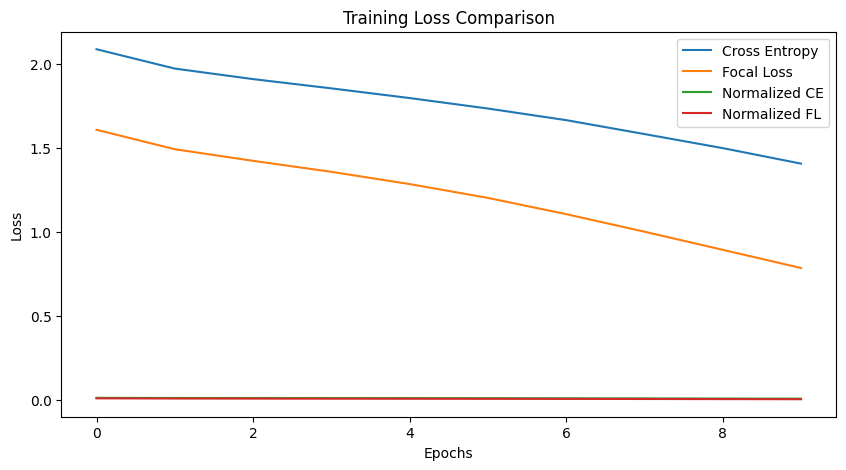

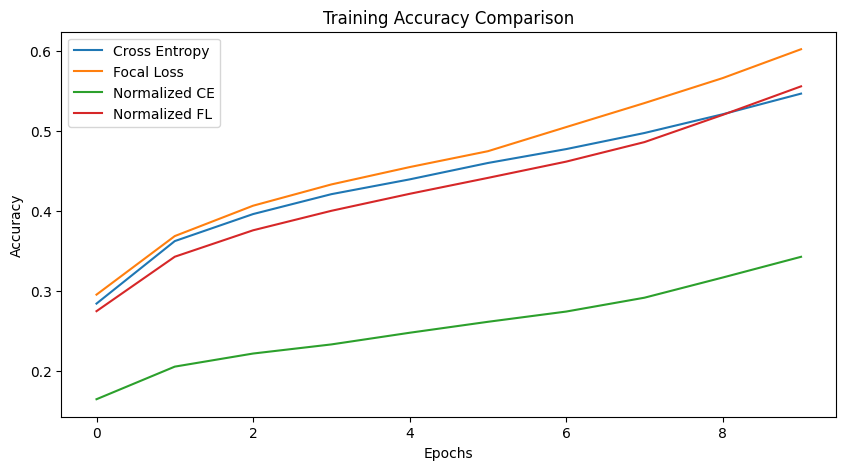

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load saved histories
ce_history = torch.load("ce_history.pth")
fl_history = torch.load("fl_history.pth")
nce_history = torch.load("nce_history.pth")
nfl_history = torch.load("nfl_history.pth")

# Plot Training Loss Comparison
plt.figure(figsize=(10, 5))
plt.plot(ce_history['train_loss'], label="Cross Entropy")
plt.plot(fl_history['train_loss'], label="Focal Loss")
plt.plot(nce_history['train_loss'], label="Normalized CE")
plt.plot(nfl_history['train_loss'], label="Normalized FL")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

# Plot Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.plot(ce_history['train_acc'], label="Cross Entropy")
plt.plot(fl_history['train_acc'], label="Focal Loss")
plt.plot(nce_history['train_acc'], label="Normalized CE")
plt.plot(nfl_history['train_acc'], label="Normalized FL")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.show()


In [ ]:
histories = {
    "Cross Entropy": ce_history,
    "Focal Loss": fl_history,
    "Normalized CE": nce_history,
    "Normalized FL": nfl_history
}

print("\nFinal Performance Summary:")
for name, history in histories.items():
    final_loss = history['train_loss'][-1]
    final_acc = history['train_acc'][-1] * 100  # Convert to percentage
    print(f"{name}: Accuracy = {final_acc:.2f}%, Final Loss = {final_loss:.4f}")

best_model = max(histories, key=lambda k: histories[k]['train_acc'][-1])
best_acc = histories[best_model]['train_acc'][-1] * 100
print(f"\n🏆 Best Model: {best_model} with Accuracy = {best_acc:.2f}%")


Final Performance Summary:
Cross Entropy: Accuracy = 54.70%, Final Loss = 1.4085
Focal Loss: Accuracy = 60.26%, Final Loss = 0.7865
Normalized CE: Accuracy = 65.92%, Final Loss = 0.0027
Normalized FL: Accuracy = 55.61%, Final Loss = 0.0047

🏆 Best Model: Normalized CE with Accuracy = 65.92%


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# Enable cuDNN Benchmarking (improves performance for fixed-size inputs like CIFAR-10)
torch.backends.cudnn.benchmark = True

# Use all available CPU cores for data loading
num_workers = os.cpu_count()

def train_model(model, train_loader,test_loader, criterion, optimizer, epochs=25, patience=3):
    model.train()
    scaler = torch.amp.GradScaler('cuda')

    best_loss = float('inf')
    best_acc = 0.0
    epochs_no_improve = 0

    # Learning Rate Scheduler: Reduce LR if loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct, total = 0, 0  # Track accuracy per epoch

        # Progress Bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed Precision Training
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backpropagation with AMP
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar with loss
            progress_bar.set_postfix(loss=loss.item())

        # Calculate average loss and accuracy for the epoch
        avg_loss = epoch_loss / len(train_loader)
        epoch_accuracy = correct / total
        print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")

        # Adjust learning rate if loss plateaus
        scheduler.step(avg_loss)

        # Convergence check (Stop if both accuracy and loss stop improving)
        if best_loss - avg_loss > 0.0001:
            best_loss = min(best_loss, avg_loss)
            best_acc = max(best_acc, epoch_accuracy)
            epochs_no_improve = 0

            # Save the best model
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Model saved!")

        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} (No improvement for {patience} epochs)")
            break

    return evaluate_model(model,test_loader)


def evaluate_model(model,test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy


# Faster Data Loaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=num_workers, pin_memory=True)

# Results Storage
results = {
    "CE": [],
    "FL": [],
    "NCE": [],
    "NFL": [],
    "APL_NCE_MAE": [],
    "APL_NCE_RCE": [],
    "APL_NFL_MAE": [],
    "APL_NFL_RCE": [],
}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ======================
# Mean Absolute Error (MAE) Loss
# ======================
class MAELoss(torch.nn.Module):
    def forward(self, outputs, labels):
        probs = F.softmax(outputs, dim=1)
        one_hot_labels = F.one_hot(labels, num_classes=outputs.size(1)).float()
        loss = torch.abs(probs - one_hot_labels).mean()
        return loss


# ======================
# Reverse Cross-Entropy (RCE) Loss
# ======================
class RCELoss(torch.nn.Module):
    def forward(self, outputs, labels):
        probs = F.softmax(outputs, dim=1)
        one_hot_labels = F.one_hot(labels, num_classes=outputs.size(1)).float()
        reverse_probs = 1.0 - probs
        loss = -torch.sum(reverse_probs * one_hot_labels, dim=1).mean()
        # Normalize RCE to prevent it from dominating
        loss /= outputs.size(1)
        return loss


# ======================
# Active Passive Loss (APL)
# ======================
class APLLoss(nn.Module):
    def __init__(self, active_loss, passive_loss, alpha=1.0, beta=1.0, debug=False):
        super(APLLoss, self).__init__()
        self.active_loss = active_loss
        self.passive_loss = passive_loss
        self.alpha = alpha
        self.beta = beta
        self.debug = debug

    def forward(self, outputs, labels):
        active = self.active_loss(outputs, labels)
        passive = self.passive_loss(outputs, labels)

        # Safe APL: Prevent negative loss by clamping
        loss = self.alpha * active + self.beta * passive
        loss = torch.clamp(loss, min=0)

      #  if self.debug:
       #     print(f"APL => Active: {active:.6f}, Passive: {passive:.6f}, Total: {loss:.6f}")

        return loss


# ======================
# Instantiate the APL combinations with safe parameters
# ======================

# Safeguard NCE + MAE (No risk of negative loss)
apl_nce_mae = APLLoss(NormalizedCrossEntropyLoss(), MAELoss(), debug=True)

# NCE + RCE (Lower beta to reduce passive loss impact)
apl_nce_rce = APLLoss(NormalizedCrossEntropyLoss(), RCELoss(), alpha=1.0, beta=0.001, debug=True)

# NFL + MAE (No risk of negative loss)
apl_nfl_mae = APLLoss(NormalizedFocalLoss(), MAELoss(), debug=True)

# NFL + RCE (Lower beta to prevent negative loss)
apl_nfl_rce = APLLoss(NormalizedFocalLoss(), RCELoss(), alpha=1.0, beta=0.001, debug=True)




✅ APL Losses are now safe! No more negative losses. 🚀


In [ ]:
noise_rates = [0.1, 0.3, 0.5, 0.7]  # Different noise levels


 {'CE': [0.678, 0.5937, 0.4565], 'FL': [0.6594, 0.6004, 0.4626], 'NCE': [0.6575, 0.5793, 0.4979], 'NFL': [0.6589, 0.597, 0.5062]}

In [ ]:
 # Train Cross-Entropy Loss Model

for noise_rate in noise_rates:


    # Train APL (NCE + MAE)
    apl_nce_mae_model = SimpleCNN().to(device)
    optimizer = optim.Adam(apl_nce_mae_model.parameters(), lr=0.001)
    apl_nce_mae_acc = train_model(apl_nce_mae_model, train_loader,test_loader, apl_nce_mae, optimizer)
    results["APL_NCE_MAE"].append(apl_nce_mae_acc)
    print(f"APL (NCE + MAE) Accuracy for Noise Rate {noise_rate}: {apl_nce_mae_acc}")
    print("Results so far:", results)

     # Train APL (NFL + MAE)
    apl_nfl_mae_model = SimpleCNN().to(device)
    optimizer = optim.Adam(apl_nfl_mae_model.parameters(), lr=0.001)
    apl_nfl_mae_acc = train_model(apl_nfl_mae_model, train_loader,test_loader, apl_nfl_mae, optimizer)
    results["APL_NFL_MAE"].append(apl_nfl_mae_acc)
    print(f"APL (NFL + MAE) Accuracy for Noise Rate {noise_rate}: {apl_nfl_mae_acc}")
    print("Results so far:", results)



    # Train APL (NCE + RCE)
    apl_nce_rce_model = SimpleCNN().to(device)
    optimizer = optim.Adam(apl_nce_rce_model.parameters(), lr=0.001)
    apl_nce_rce_acc = train_model(apl_nce_rce_model, train_loader,test_loader, apl_nce_rce, optimizer)
    results["APL_NCE_RCE"].append(apl_nce_rce_acc)
    print(f"APL (NCE + RCE) Accuracy for Noise Rate {noise_rate}: {apl_nce_rce_acc}")
    print("Results so far:", results)



    # Train APL (NFL + RCE)
    apl_nfl_rce_model = SimpleCNN().to(device)
    optimizer = optim.Adam(apl_nfl_rce_model.parameters(), lr=0.001)
    apl_nfl_rce_acc = train_model(apl_nfl_rce_model, train_loader,test_loader, apl_nfl_rce, optimizer)
    results["APL_NFL_RCE"].append(apl_nfl_rce_acc)
    print(f"APL (NFL + RCE) Accuracy for Noise Rate {noise_rate}: {apl_nfl_rce_acc}")
    print("Results so far:", results)


IndentationError: unexpected indent (<ipython-input-33-55f780be440e>, line 2)

In [ ]:

for noise_rate in noise_rates:
    print(f"\nTraining APL models with noise rate: {noise_rate}")

    # Create noisy dataset
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
    noisy_labels = add_symmetric_noise(train_dataset.targets, noise_rate, num_classes)
    train_dataset.targets = noisy_labels  # Overwrite labels with noisy ones

    noisy_labels_test = add_symmetric_noise(test_dataset.targets, noise_rate, num_classes)
    test_dataset.targets = noisy_labels_test  # Overwrite labels with noisy ones
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=num_workers, pin_memory=True)




    ce_model = SimpleCNN().to(device)
    ce_criterion = CrossEntropyLoss().to(device)
    ce_optimizer = optim.Adam(ce_model.parameters(), lr=0.001)
    ce_acc = train_model(ce_model, train_loader, test_loader ,ce_criterion, ce_optimizer)
    results["CE"].append(ce_acc)
    print(f"CE Accuracy for Noise Rate {noise_rate}: {ce_acc}")
    print("Results so far:", results)

    # Train Focal Loss Model
    fl_model = SimpleCNN().to(device)
    fl_criterion = NormalizedFocalLoss().to(device)  # Replace with actual FocalLoss
    fl_optimizer = optim.Adam(fl_model.parameters(), lr=0.001)
    fl_acc = train_model(fl_model, train_loader, test_loader,fl_criterion, fl_optimizer)
    results["FL"].append(fl_acc)
    print(f"FL Accuracy for Noise Rate {noise_rate}: {fl_acc}")
    print("Results so far:", results)

    # Train Normalized Cross-Entropy Model
    nce_model = SimpleCNN().to(device)
    nce_criterion = NormalizedCrossEntropyLoss().to(device)  # Replace with actual NCE Loss
    nce_optimizer = optim.Adam(nce_model.parameters(), lr=0.001)
    nce_acc = train_model(nce_model, train_loader, test_loader,nce_criterion, nce_optimizer)
    results["NCE"].append(nce_acc)
    print(f"NCE Accuracy for Noise Rate {noise_rate}: {nce_acc}")
    print("Results so far:", results)

    # Train Normalized Focal Loss Model
    nfl_model = SimpleCNN().to(device)
    nfl_criterion = NormalizedFocalLoss().to(device)  # Replace with actual NFL Loss
    nfl_optimizer = optim.Adam(nfl_model.parameters(), lr=0.001)
    nfl_acc = train_model(nfl_model, train_loader,test_loader,nfl_criterion, nfl_optimizer)
    results["NFL"].append(nfl_acc)
    print(f"NFL Accuracy for Noise Rate {noise_rate}: {nfl_acc}")
    print("Results so far:", results)

# Save results
torch.save(results, "apl_accuracy_vs_noise.pth")



Training APL models with noise rate: 0.1


Epoch 1/25 - Avg Loss: 1.7942 - Accuracy: 0.3783
✅ Model saved!


Epoch 2/25 - Avg Loss: 1.5247 - Accuracy: 0.4994
✅ Model saved!


Epoch 3/25 - Avg Loss: 1.4224 - Accuracy: 0.5446
✅ Model saved!


Epoch 4/25 - Avg Loss: 1.3418 - Accuracy: 0.5794
✅ Model saved!


Epoch 5/25 - Avg Loss: 1.2873 - Accuracy: 0.6037
✅ Model saved!


Epoch 6/25 - Avg Loss: 1.2344 - Accuracy: 0.6202
✅ Model saved!


Epoch 7/25 - Avg Loss: 1.1847 - Accuracy: 0.6435
✅ Model saved!


Epoch 8/25 - Avg Loss: 1.1439 - Accuracy: 0.6586
✅ Model saved!


Epoch 9/25 - Avg Loss: 1.1085 - Accuracy: 0.6709
✅ Model saved!


Epoch 10/25 - Avg Loss: 1.0639 - Accuracy: 0.6870
✅ Model saved!


Epoch 11/25 - Avg Loss: 1.0294 - Accuracy: 0.6987
✅ Model saved!


Epoch 12/25 - Avg Loss: 0.9941 - Accuracy: 0.7104
✅ Model saved!


Epoch 13/25 - Avg Loss: 0.9493 - Accuracy: 0.7233
✅ Model saved!


Epoch 14/25 - Avg Loss: 0.9123 - Accuracy: 0.7357
✅ Model saved!


Epoch 15/25 - Avg Loss: 0.8698 - Accuracy: 0.7462
✅ Model saved!


Epoch 16/25 - Avg Loss: 0.8222 - Accuracy: 0.7608
✅ Model saved!


Epoch 17/25 - Avg Loss: 0.7807 - Accuracy: 0.7738
✅ Model saved!


Epoch 18/25 - Avg Loss: 0.7323 - Accuracy: 0.7881
✅ Model saved!


Epoch 19/25 - Avg Loss: 0.6861 - Accuracy: 0.8008
✅ Model saved!


Epoch 20/25 - Avg Loss: 0.6414 - Accuracy: 0.8132
✅ Model saved!


Epoch 21/25 - Avg Loss: 0.5913 - Accuracy: 0.8281
✅ Model saved!


Epoch 22/25 - Avg Loss: 0.5488 - Accuracy: 0.8412
✅ Model saved!


Epoch 23/25 - Avg Loss: 0.5057 - Accuracy: 0.8532
✅ Model saved!


Epoch 24/25 - Avg Loss: 0.4591 - Accuracy: 0.8673
✅ Model saved!


Epoch 25/25 - Avg Loss: 0.4118 - Accuracy: 0.8815
✅ Model saved!


Test Accuracy: 0.5866
CE Accuracy for Noise Rate 0.1: 0.5866
Results so far: {'CE': [0.5866], 'FL': [], 'NCE': [], 'NFL': [], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0009 - Accuracy: 0.3423
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0006 - Accuracy: 0.4621
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0006 - Accuracy: 0.5036


Epoch 4/25 - Avg Loss: 0.0005 - Accuracy: 0.5296


Epoch 5/25 - Avg Loss: 0.0005 - Accuracy: 0.5526
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.0005 - Accuracy: 0.5755


Epoch 7/25 - Avg Loss: 0.0005 - Accuracy: 0.5928


Epoch 8/25 - Avg Loss: 0.0004 - Accuracy: 0.6081
Early stopping at epoch 8 (No improvement for 3 epochs)


Test Accuracy: 0.5971
FL Accuracy for Noise Rate 0.1: 0.5971
Results so far: {'CE': [0.5866], 'FL': [0.5971], 'NCE': [], 'NFL': [], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0009 - Accuracy: 0.3457
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0006 - Accuracy: 0.4650
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0006 - Accuracy: 0.5081


Epoch 4/25 - Avg Loss: 0.0005 - Accuracy: 0.5325


Epoch 5/25 - Avg Loss: 0.0005 - Accuracy: 0.5606
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.0005 - Accuracy: 0.5771


Epoch 7/25 - Avg Loss: 0.0005 - Accuracy: 0.5948


Epoch 8/25 - Avg Loss: 0.0004 - Accuracy: 0.6135
Early stopping at epoch 8 (No improvement for 3 epochs)


Test Accuracy: 0.5854
NCE Accuracy for Noise Rate 0.1: 0.5854
Results so far: {'CE': [0.5866], 'FL': [0.5971], 'NCE': [0.5854], 'NFL': [], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0010 - Accuracy: 0.3333
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0007 - Accuracy: 0.4539
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0006 - Accuracy: 0.4914


Epoch 4/25 - Avg Loss: 0.0006 - Accuracy: 0.5162


Epoch 5/25 - Avg Loss: 0.0005 - Accuracy: 0.5433
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.0005 - Accuracy: 0.5615


Epoch 7/25 - Avg Loss: 0.0005 - Accuracy: 0.5791


Epoch 8/25 - Avg Loss: 0.0005 - Accuracy: 0.5960
Early stopping at epoch 8 (No improvement for 3 epochs)


Test Accuracy: 0.5777
NFL Accuracy for Noise Rate 0.1: 0.5777
Results so far: {'CE': [0.5866], 'FL': [0.5971], 'NCE': [0.5854], 'NFL': [0.5777], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}

Training APL models with noise rate: 0.3


Epoch 1/25 - Avg Loss: 2.0341 - Accuracy: 0.3035
✅ Model saved!


Epoch 2/25 - Avg Loss: 1.8827 - Accuracy: 0.3918
✅ Model saved!


Epoch 3/25 - Avg Loss: 1.8147 - Accuracy: 0.4290
✅ Model saved!


Epoch 4/25 - Avg Loss: 1.7609 - Accuracy: 0.4555
✅ Model saved!


Epoch 5/25 - Avg Loss: 1.7210 - Accuracy: 0.4734
✅ Model saved!


Epoch 6/25 - Avg Loss: 1.6840 - Accuracy: 0.4902
✅ Model saved!


Epoch 7/25 - Avg Loss: 1.6475 - Accuracy: 0.5037
✅ Model saved!


Epoch 8/25 - Avg Loss: 1.6089 - Accuracy: 0.5158
✅ Model saved!


Epoch 9/25 - Avg Loss: 1.5713 - Accuracy: 0.5285
✅ Model saved!


Epoch 10/25 - Avg Loss: 1.5290 - Accuracy: 0.5406
✅ Model saved!


Epoch 11/25 - Avg Loss: 1.4915 - Accuracy: 0.5507
✅ Model saved!


Epoch 12/25 - Avg Loss: 1.4422 - Accuracy: 0.5639
✅ Model saved!


Epoch 13/25 - Avg Loss: 1.3982 - Accuracy: 0.5763
✅ Model saved!


Epoch 14/25 - Avg Loss: 1.3461 - Accuracy: 0.5885
✅ Model saved!


Epoch 15/25 - Avg Loss: 1.2884 - Accuracy: 0.6056
✅ Model saved!


Epoch 16/25 - Avg Loss: 1.2331 - Accuracy: 0.6198
✅ Model saved!


Epoch 17/25 - Avg Loss: 1.1746 - Accuracy: 0.6363
✅ Model saved!


Epoch 18/25 - Avg Loss: 1.1155 - Accuracy: 0.6513
✅ Model saved!


Epoch 19/25 - Avg Loss: 1.0505 - Accuracy: 0.6705
✅ Model saved!


Epoch 20/25 - Avg Loss: 0.9866 - Accuracy: 0.6898
✅ Model saved!


Epoch 21/25 - Avg Loss: 0.9255 - Accuracy: 0.7086
✅ Model saved!


Epoch 22/25 - Avg Loss: 0.8709 - Accuracy: 0.7258
✅ Model saved!


Epoch 23/25 - Avg Loss: 0.8062 - Accuracy: 0.7459
✅ Model saved!


Epoch 24/25 - Avg Loss: 0.7558 - Accuracy: 0.7615
✅ Model saved!


Epoch 25/25 - Avg Loss: 0.6889 - Accuracy: 0.7839
✅ Model saved!


Test Accuracy: 0.3728
CE Accuracy for Noise Rate 0.3: 0.3728
Results so far: {'CE': [0.5866, 0.3728], 'FL': [0.5971], 'NCE': [0.5854], 'NFL': [0.5777], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0012 - Accuracy: 0.2662
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0010 - Accuracy: 0.3505
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0010 - Accuracy: 0.3785


Epoch 4/25 - Avg Loss: 0.0009 - Accuracy: 0.4041


Epoch 5/25 - Avg Loss: 0.0009 - Accuracy: 0.4189
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.0009 - Accuracy: 0.4354


Epoch 7/25 - Avg Loss: 0.0008 - Accuracy: 0.4513


Epoch 8/25 - Avg Loss: 0.0008 - Accuracy: 0.4631
Early stopping at epoch 8 (No improvement for 3 epochs)


Test Accuracy: 0.4471
FL Accuracy for Noise Rate 0.3: 0.4471
Results so far: {'CE': [0.5866, 0.3728], 'FL': [0.5971, 0.4471], 'NCE': [0.5854], 'NFL': [0.5777], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0012 - Accuracy: 0.2632
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0010 - Accuracy: 0.3435
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0010 - Accuracy: 0.3742


Epoch 4/25 - Avg Loss: 0.0009 - Accuracy: 0.3988


Epoch 5/25 - Avg Loss: 0.0009 - Accuracy: 0.4196
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.0009 - Accuracy: 0.4341


Epoch 7/25 - Avg Loss: 0.0008 - Accuracy: 0.4503


Epoch 8/25 - Avg Loss: 0.0008 - Accuracy: 0.4637
Early stopping at epoch 8 (No improvement for 3 epochs)


Test Accuracy: 0.4443
NCE Accuracy for Noise Rate 0.3: 0.4443
Results so far: {'CE': [0.5866, 0.3728], 'FL': [0.5971, 0.4471], 'NCE': [0.5854, 0.4443], 'NFL': [0.5777], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0013 - Accuracy: 0.2506
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0010 - Accuracy: 0.3462
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0010 - Accuracy: 0.3793


Epoch 4/25 - Avg Loss: 0.0009 - Accuracy: 0.4010


Epoch 5/25 - Avg Loss: 0.0009 - Accuracy: 0.4186
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.0009 - Accuracy: 0.4336


Epoch 7/25 - Avg Loss: 0.0009 - Accuracy: 0.4500


Epoch 8/25 - Avg Loss: 0.0008 - Accuracy: 0.4565
Early stopping at epoch 8 (No improvement for 3 epochs)


Test Accuracy: 0.4431
NFL Accuracy for Noise Rate 0.3: 0.4431
Results so far: {'CE': [0.5866, 0.3728], 'FL': [0.5971, 0.4471], 'NCE': [0.5854, 0.4443], 'NFL': [0.5777, 0.4431], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}

Training APL models with noise rate: 0.5


Epoch 1/25 - Avg Loss: 2.2069 - Accuracy: 0.2108
✅ Model saved!


Epoch 2/25 - Avg Loss: 2.1307 - Accuracy: 0.2756
✅ Model saved!


Epoch 3/25 - Avg Loss: 2.0927 - Accuracy: 0.3012
✅ Model saved!


Epoch 4/25 - Avg Loss: 2.0623 - Accuracy: 0.3190
✅ Model saved!


Epoch 5/25 - Avg Loss: 2.0344 - Accuracy: 0.3309
✅ Model saved!


Epoch 6/25 - Avg Loss: 2.0021 - Accuracy: 0.3506
✅ Model saved!


Epoch 7/25 - Avg Loss: 1.9724 - Accuracy: 0.3597
✅ Model saved!


Epoch 8/25 - Avg Loss: 1.9379 - Accuracy: 0.3715
✅ Model saved!


Epoch 9/25 - Avg Loss: 1.8962 - Accuracy: 0.3863
✅ Model saved!


Epoch 10/25 - Avg Loss: 1.8483 - Accuracy: 0.3993
✅ Model saved!


Epoch 11/25 - Avg Loss: 1.7981 - Accuracy: 0.4131
✅ Model saved!


Epoch 12/25 - Avg Loss: 1.7435 - Accuracy: 0.4300
✅ Model saved!


Epoch 13/25 - Avg Loss: 1.6781 - Accuracy: 0.4487
✅ Model saved!


Epoch 14/25 - Avg Loss: 1.6109 - Accuracy: 0.4667
✅ Model saved!


Epoch 15/25 - Avg Loss: 1.5412 - Accuracy: 0.4884
✅ Model saved!


Epoch 16/25 - Avg Loss: 1.4741 - Accuracy: 0.5117
✅ Model saved!


Epoch 17/25 - Avg Loss: 1.3962 - Accuracy: 0.5384
✅ Model saved!


Epoch 18/25 - Avg Loss: 1.3281 - Accuracy: 0.5620
✅ Model saved!


Epoch 19/25 - Avg Loss: 1.2575 - Accuracy: 0.5852
✅ Model saved!


Epoch 20/25 - Avg Loss: 1.1813 - Accuracy: 0.6105
✅ Model saved!


Epoch 21/25 - Avg Loss: 1.1109 - Accuracy: 0.6326
✅ Model saved!


Epoch 22/25 - Avg Loss: 1.0526 - Accuracy: 0.6522
✅ Model saved!


Epoch 23/25 - Avg Loss: 0.9804 - Accuracy: 0.6775
✅ Model saved!


Epoch 24/25 - Avg Loss: 0.9225 - Accuracy: 0.6977
✅ Model saved!


Epoch 25/25 - Avg Loss: 0.8511 - Accuracy: 0.7220
✅ Model saved!


Test Accuracy: 0.2152
CE Accuracy for Noise Rate 0.5: 0.2152
Results so far: {'CE': [0.5866, 0.3728, 0.2152], 'FL': [0.5971, 0.4471], 'NCE': [0.5854, 0.4443], 'NFL': [0.5777, 0.4431], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0015 - Accuracy: 0.2003
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0013 - Accuracy: 0.2493
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0013 - Accuracy: 0.2741


Epoch 4/25 - Avg Loss: 0.0013 - Accuracy: 0.2854


Epoch 5/25 - Avg Loss: 0.0013 - Accuracy: 0.2952
Early stopping at epoch 5 (No improvement for 3 epochs)


Test Accuracy: 0.2880
FL Accuracy for Noise Rate 0.5: 0.288
Results so far: {'CE': [0.5866, 0.3728, 0.2152], 'FL': [0.5971, 0.4471, 0.288], 'NCE': [0.5854, 0.4443], 'NFL': [0.5777, 0.4431], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0015 - Accuracy: 0.1933
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0013 - Accuracy: 0.2541
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0013 - Accuracy: 0.2763


Epoch 4/25 - Avg Loss: 0.0013 - Accuracy: 0.2898


Epoch 5/25 - Avg Loss: 0.0013 - Accuracy: 0.3004
Early stopping at epoch 5 (No improvement for 3 epochs)


Test Accuracy: 0.2938
NCE Accuracy for Noise Rate 0.5: 0.2938
Results so far: {'CE': [0.5866, 0.3728, 0.2152], 'FL': [0.5971, 0.4471, 0.288], 'NCE': [0.5854, 0.4443, 0.2938], 'NFL': [0.5777, 0.4431], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0015 - Accuracy: 0.1965
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0014 - Accuracy: 0.2495
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0013 - Accuracy: 0.2747


Epoch 4/25 - Avg Loss: 0.0013 - Accuracy: 0.2858


Epoch 5/25 - Avg Loss: 0.0013 - Accuracy: 0.2970
Early stopping at epoch 5 (No improvement for 3 epochs)


Test Accuracy: 0.2930
NFL Accuracy for Noise Rate 0.5: 0.293
Results so far: {'CE': [0.5866, 0.3728, 0.2152], 'FL': [0.5971, 0.4471, 0.288], 'NCE': [0.5854, 0.4443, 0.2938], 'NFL': [0.5777, 0.4431, 0.293], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}

Training APL models with noise rate: 0.7


Epoch 1/25 - Avg Loss: 2.2865 - Accuracy: 0.1419
✅ Model saved!


Epoch 2/25 - Avg Loss: 2.2634 - Accuracy: 0.1740
✅ Model saved!


Epoch 3/25 - Avg Loss: 2.2465 - Accuracy: 0.1905
✅ Model saved!


Epoch 4/25 - Avg Loss: 2.2261 - Accuracy: 0.2064
✅ Model saved!


Epoch 5/25 - Avg Loss: 2.2037 - Accuracy: 0.2161
✅ Model saved!


Epoch 6/25 - Avg Loss: 2.1760 - Accuracy: 0.2312
✅ Model saved!


Epoch 7/25 - Avg Loss: 2.1402 - Accuracy: 0.2450
✅ Model saved!


Epoch 8/25 - Avg Loss: 2.0926 - Accuracy: 0.2651
✅ Model saved!


Epoch 9/25 - Avg Loss: 2.0305 - Accuracy: 0.2877
✅ Model saved!


Epoch 10/25 - Avg Loss: 1.9597 - Accuracy: 0.3155
✅ Model saved!


Epoch 11/25 - Avg Loss: 1.8879 - Accuracy: 0.3437
✅ Model saved!


Epoch 12/25 - Avg Loss: 1.8061 - Accuracy: 0.3744
✅ Model saved!


Epoch 13/25 - Avg Loss: 1.7125 - Accuracy: 0.4089
✅ Model saved!


Epoch 14/25 - Avg Loss: 1.6251 - Accuracy: 0.4435
✅ Model saved!


Epoch 15/25 - Avg Loss: 1.5332 - Accuracy: 0.4768
✅ Model saved!


Epoch 16/25 - Avg Loss: 1.4424 - Accuracy: 0.5087
✅ Model saved!


Epoch 17/25 - Avg Loss: 1.3491 - Accuracy: 0.5432
✅ Model saved!


Epoch 18/25 - Avg Loss: 1.2669 - Accuracy: 0.5718
✅ Model saved!


Epoch 19/25 - Avg Loss: 1.1779 - Accuracy: 0.6048
✅ Model saved!


Epoch 20/25 - Avg Loss: 1.0936 - Accuracy: 0.6350
✅ Model saved!


Epoch 21/25 - Avg Loss: 1.0135 - Accuracy: 0.6616
✅ Model saved!


Epoch 22/25 - Avg Loss: 0.9370 - Accuracy: 0.6917
✅ Model saved!


Epoch 23/25 - Avg Loss: 0.8606 - Accuracy: 0.7177
✅ Model saved!


Epoch 24/25 - Avg Loss: 0.7854 - Accuracy: 0.7453
✅ Model saved!


Epoch 25/25 - Avg Loss: 0.7144 - Accuracy: 0.7702
✅ Model saved!


Test Accuracy: 0.1290
CE Accuracy for Noise Rate 0.7: 0.129
Results so far: {'CE': [0.5866, 0.3728, 0.2152, 0.129], 'FL': [0.5971, 0.4471, 0.288], 'NCE': [0.5854, 0.4443, 0.2938], 'NFL': [0.5777, 0.4431, 0.293], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0018 - Accuracy: 0.1323
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0017 - Accuracy: 0.1595
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0017 - Accuracy: 0.1702


Epoch 4/25 - Avg Loss: 0.0016 - Accuracy: 0.1785


Epoch 5/25 - Avg Loss: 0.0016 - Accuracy: 0.1854
Early stopping at epoch 5 (No improvement for 3 epochs)


Test Accuracy: 0.1772
FL Accuracy for Noise Rate 0.7: 0.1772
Results so far: {'CE': [0.5866, 0.3728, 0.2152, 0.129], 'FL': [0.5971, 0.4471, 0.288, 0.1772], 'NCE': [0.5854, 0.4443, 0.2938], 'NFL': [0.5777, 0.4431, 0.293], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0018 - Accuracy: 0.1317
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0017 - Accuracy: 0.1604


Epoch 3/25 - Avg Loss: 0.0017 - Accuracy: 0.1710
✅ Model saved!


Epoch 4/25 - Avg Loss: 0.0016 - Accuracy: 0.1799


Epoch 5/25 - Avg Loss: 0.0016 - Accuracy: 0.1844


Epoch 6/25 - Avg Loss: 0.0016 - Accuracy: 0.1898
Early stopping at epoch 6 (No improvement for 3 epochs)


Test Accuracy: 0.1814
NCE Accuracy for Noise Rate 0.7: 0.1814
Results so far: {'CE': [0.5866, 0.3728, 0.2152, 0.129], 'FL': [0.5971, 0.4471, 0.288, 0.1772], 'NCE': [0.5854, 0.4443, 0.2938, 0.1814], 'NFL': [0.5777, 0.4431, 0.293], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


Epoch 1/25 - Avg Loss: 0.0018 - Accuracy: 0.1342
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0017 - Accuracy: 0.1607


Epoch 3/25 - Avg Loss: 0.0016 - Accuracy: 0.1714
✅ Model saved!


Epoch 4/25 - Avg Loss: 0.0016 - Accuracy: 0.1794


Epoch 5/25 - Avg Loss: 0.0016 - Accuracy: 0.1852


Epoch 6/25 - Avg Loss: 0.0016 - Accuracy: 0.1905
Early stopping at epoch 6 (No improvement for 3 epochs)


Test Accuracy: 0.1761
NFL Accuracy for Noise Rate 0.7: 0.1761
Results so far: {'CE': [0.5866, 0.3728, 0.2152, 0.129], 'FL': [0.5971, 0.4471, 0.288, 0.1772], 'NCE': [0.5854, 0.4443, 0.2938, 0.1814], 'NFL': [0.5777, 0.4431, 0.293, 0.1761], 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876], 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824], 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185], 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}


In [ ]:
!nvidia-smi


In [ ]:
# Plot Accuracy vs Noise Rate
plt.figure(figsize=(16, 20))
for model, acc in results.items():
    if len(acc) > 0:  # Only plot non-empty lists
        plt.plot(noise_rates, acc, marker='o', label=model)

plt.xlabel("Noise Rate")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs. Noise Rate for Different Loss Functions")
plt.legend()
plt.grid()
plt.show()

In [ ]:
results

{'CE': [0.5866, 0.3728, 0.2152, 0.129],
 'FL': [0.5971, 0.4471, 0.288, 0.1772],
 'NCE': [0.5854, 0.4443, 0.2938, 0.1814],
 'NFL': [0.5777, 0.4431, 0.293, 0.1761],
 'APL_NCE_MAE': [0.6138, 0.4692, 0.3255, 0.1876],
 'APL_NCE_RCE': [0.5669, 0.4396, 0.2963, 0.1824],
 'APL_NFL_MAE': [0.6131, 0.4724, 0.3345, 0.185],
 'APL_NFL_RCE': [0.5834, 0.426, 0.2927, 0.1854]}

unsymmetric noise

In [ ]:
# Results Storage
results = {
    "CE": [],
    "FL": [],
    "NCE": [],
    "NFL": [],
    "APL_NCE_MAE": [],
    "APL_NCE_RCE": [],
    "APL_NFL_MAE": [],
    "APL_NFL_RCE": [],
}

In [ ]:
import numpy as np

def add_asymmetric_noise(labels, noise_rate, noise_map):

    labels = np.array(labels)        # Ensure we have a NumPy array
    noisy_labels = labels.copy()
    num_samples = len(labels)

    # How many samples to corrupt?
    num_noisy = int(noise_rate * num_samples)

    # Randomly choose which indices to corrupt
    noisy_indices = np.random.choice(num_samples, num_noisy, replace=False)

    # For each chosen index, flip the label according to the noise_map
    for idx in noisy_indices:
        original_label = labels[idx]
        # Only flip if this original_label is in the noise map
        if original_label in noise_map:
            new_label = noise_map[original_label]
            noisy_labels[idx] = new_label

    return noisy_labels



example_noise_map = {
    9: 1,  # truck -> automobile
    2: 0,  # bird  -> airplane
    4: 7,  # deer  -> horse
    3: 5,  # cat   -> dog
    5: 3   # dog   -> cat
}



In [ ]:
noise_rates =[0.1,0.2,0.3,0.4]

In [ ]:

for noise_rate in noise_rates:
    print(f"\nTraining APL models with noise rate: {noise_rate}")

    # Create noisy dataset
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
    train_dataset.targets = add_asymmetric_noise(train_dataset.targets, noise_rate, example_noise_map)

    test_dataset.targets = add_asymmetric_noise(test_dataset.targets, noise_rate, example_noise_map)

    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=num_workers, pin_memory=True)




    ce_model = SimpleCNN().to(device)
    ce_criterion = CrossEntropyLoss().to(device)
    ce_optimizer = optim.Adam(ce_model.parameters(), lr=0.001)
    ce_acc = train_model(ce_model, train_loader, test_loader ,ce_criterion, ce_optimizer)
    results["CE"].append(ce_acc)
    print(f"CE Accuracy for Noise Rate {noise_rate}: {ce_acc}")
    print("Results so far:", results)

    # Train Focal Loss Model
    fl_model = SimpleCNN().to(device)
    fl_criterion = NormalizedFocalLoss().to(device)  # Replace with actual FocalLoss
    fl_optimizer = optim.Adam(fl_model.parameters(), lr=0.001)
    fl_acc = train_model(fl_model, train_loader, test_loader,fl_criterion, fl_optimizer)
    results["FL"].append(fl_acc)
    print(f"FL Accuracy for Noise Rate {noise_rate}: {fl_acc}")
    print("Results so far:", results)

    # Train Normalized Cross-Entropy Model
    nce_model = SimpleCNN().to(device)
    nce_criterion = NormalizedCrossEntropyLoss().to(device)  # Replace with actual NCE Loss
    nce_optimizer = optim.Adam(nce_model.parameters(), lr=0.001)
    nce_acc = train_model(nce_model, train_loader, test_loader,nce_criterion, nce_optimizer)
    results["NCE"].append(nce_acc)
    print(f"NCE Accuracy for Noise Rate {noise_rate}: {nce_acc}")
    print("Results so far:", results)

    # Train Normalized Focal Loss Model
    nfl_model = SimpleCNN().to(device)
    nfl_criterion = NormalizedFocalLoss().to(device)  # Replace with actual NFL Loss
    nfl_optimizer = optim.Adam(nfl_model.parameters(), lr=0.001)
    nfl_acc = train_model(nfl_model, train_loader,test_loader,nfl_criterion, nfl_optimizer)
    results["NFL"].append(nfl_acc)
    print(f"NFL Accuracy for Noise Rate {noise_rate}: {nfl_acc}")
    print("Results so far:", results)

# Save results
torch.save(results, "apl_accuracy_vs_noise.pth")



Training APL models with noise rate: 0.1


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25 - Avg Loss: 1.6421 - Accuracy: 0.4121
✅ Model saved!


Epoch 2/25 - Avg Loss: 1.3129 - Accuracy: 0.5352
✅ Model saved!


Epoch 3/25 - Avg Loss: 1.1839 - Accuracy: 0.5839
✅ Model saved!


Epoch 4/25 - Avg Loss: 1.0973 - Accuracy: 0.6158
✅ Model saved!


Epoch 5/25 - Avg Loss: 1.0148 - Accuracy: 0.6460
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.9592 - Accuracy: 0.6667
✅ Model saved!


Epoch 7/25 - Avg Loss: 0.9052 - Accuracy: 0.6867
✅ Model saved!


Epoch 8/25 - Avg Loss: 0.8673 - Accuracy: 0.6968
✅ Model saved!


Epoch 9/25 - Avg Loss: 0.8225 - Accuracy: 0.7126
✅ Model saved!


Epoch 10/25 - Avg Loss: 0.7807 - Accuracy: 0.7285
✅ Model saved!


Epoch 11/25 - Avg Loss: 0.7469 - Accuracy: 0.7399
✅ Model saved!


Epoch 12/25 - Avg Loss: 0.7129 - Accuracy: 0.7511
✅ Model saved!


Epoch 13/25 - Avg Loss: 0.6728 - Accuracy: 0.7657
✅ Model saved!


Epoch 14/25 - Avg Loss: 0.6343 - Accuracy: 0.7803
✅ Model saved!


Epoch 15/25 - Avg Loss: 0.6035 - Accuracy: 0.7921
✅ Model saved!


Epoch 16/25 - Avg Loss: 0.5661 - Accuracy: 0.8032
✅ Model saved!


Epoch 17/25 - Avg Loss: 0.5356 - Accuracy: 0.8149
✅ Model saved!


Epoch 18/25 - Avg Loss: 0.4970 - Accuracy: 0.8269
✅ Model saved!


Epoch 19/25 - Avg Loss: 0.4579 - Accuracy: 0.8436
✅ Model saved!


Epoch 20/25 - Avg Loss: 0.4230 - Accuracy: 0.8560
✅ Model saved!


Epoch 21/25 - Avg Loss: 0.3958 - Accuracy: 0.8649
✅ Model saved!


Epoch 22/25 - Avg Loss: 0.3668 - Accuracy: 0.8760
✅ Model saved!


Epoch 23/25 - Avg Loss: 0.3321 - Accuracy: 0.8891
✅ Model saved!


Epoch 24/25 - Avg Loss: 0.3000 - Accuracy: 0.9021
✅ Model saved!


Epoch 25/25 - Avg Loss: 0.2591 - Accuracy: 0.9176
✅ Model saved!


Test Accuracy: 0.6673
CE Accuracy for Noise Rate 0.1: 0.6673
Results so far: {'CE': [0.6673], 'FL': [], 'NCE': [], 'NFL': [], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0008 - Accuracy: 0.3801
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.5016
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0004 - Accuracy: 0.5412


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5732
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.6019


Epoch 6/25 - Avg Loss: 0.0003 - Accuracy: 0.6254


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.6442
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.6135
FL Accuracy for Noise Rate 0.1: 0.6135
Results so far: {'CE': [0.6673], 'FL': [0.6135], 'NCE': [], 'NFL': [], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0008 - Accuracy: 0.3713
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4879
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0004 - Accuracy: 0.5439


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5764
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5954


Epoch 6/25 - Avg Loss: 0.0003 - Accuracy: 0.6179


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.6354
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.6290
NCE Accuracy for Noise Rate 0.1: 0.629
Results so far: {'CE': [0.6673], 'FL': [0.6135], 'NCE': [0.629], 'NFL': [], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0008 - Accuracy: 0.3701
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4848
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0004 - Accuracy: 0.5392


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5712
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5943


Epoch 6/25 - Avg Loss: 0.0003 - Accuracy: 0.6156


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.6353
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.6183
NFL Accuracy for Noise Rate 0.1: 0.6183
Results so far: {'CE': [0.6673], 'FL': [0.6135], 'NCE': [0.629], 'NFL': [0.6183], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}

Training APL models with noise rate: 0.2


Epoch 1/25 - Avg Loss: 1.6669 - Accuracy: 0.3999
✅ Model saved!


Epoch 2/25 - Avg Loss: 1.3386 - Accuracy: 0.5219
✅ Model saved!


Epoch 3/25 - Avg Loss: 1.2125 - Accuracy: 0.5675
✅ Model saved!


Epoch 4/25 - Avg Loss: 1.1203 - Accuracy: 0.6000
✅ Model saved!


Epoch 5/25 - Avg Loss: 1.0465 - Accuracy: 0.6274
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.9872 - Accuracy: 0.6473
✅ Model saved!


Epoch 7/25 - Avg Loss: 0.9432 - Accuracy: 0.6629
✅ Model saved!


Epoch 8/25 - Avg Loss: 0.8970 - Accuracy: 0.6785
✅ Model saved!


Epoch 9/25 - Avg Loss: 0.8635 - Accuracy: 0.6902
✅ Model saved!


Epoch 10/25 - Avg Loss: 0.8262 - Accuracy: 0.7035
✅ Model saved!


Epoch 11/25 - Avg Loss: 0.7898 - Accuracy: 0.7171
✅ Model saved!


Epoch 12/25 - Avg Loss: 0.7538 - Accuracy: 0.7305
✅ Model saved!


Epoch 13/25 - Avg Loss: 0.7258 - Accuracy: 0.7391
✅ Model saved!


Epoch 14/25 - Avg Loss: 0.6838 - Accuracy: 0.7545
✅ Model saved!


Epoch 15/25 - Avg Loss: 0.6453 - Accuracy: 0.7696
✅ Model saved!


Epoch 16/25 - Avg Loss: 0.6162 - Accuracy: 0.7794
✅ Model saved!


Epoch 17/25 - Avg Loss: 0.5816 - Accuracy: 0.7921
✅ Model saved!


Epoch 18/25 - Avg Loss: 0.5499 - Accuracy: 0.8028
✅ Model saved!


Epoch 19/25 - Avg Loss: 0.5109 - Accuracy: 0.8192
✅ Model saved!


Epoch 20/25 - Avg Loss: 0.4742 - Accuracy: 0.8330
✅ Model saved!


Epoch 21/25 - Avg Loss: 0.4442 - Accuracy: 0.8444
✅ Model saved!


Epoch 22/25 - Avg Loss: 0.4113 - Accuracy: 0.8555
✅ Model saved!


Epoch 23/25 - Avg Loss: 0.3759 - Accuracy: 0.8694
✅ Model saved!


Epoch 24/25 - Avg Loss: 0.3435 - Accuracy: 0.8832
✅ Model saved!


Epoch 25/25 - Avg Loss: 0.3096 - Accuracy: 0.8942
✅ Model saved!


Test Accuracy: 0.6294
CE Accuracy for Noise Rate 0.2: 0.6294
Results so far: {'CE': [0.6673, 0.6294], 'FL': [0.6135], 'NCE': [0.629], 'NFL': [0.6183], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0008 - Accuracy: 0.3587
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4767
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0005 - Accuracy: 0.5255


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5533
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5802


Epoch 6/25 - Avg Loss: 0.0003 - Accuracy: 0.5982


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.6208
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.6083
FL Accuracy for Noise Rate 0.2: 0.6083
Results so far: {'CE': [0.6673, 0.6294], 'FL': [0.6135, 0.6083], 'NCE': [0.629], 'NFL': [0.6183], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0009 - Accuracy: 0.3517
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4807
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0004 - Accuracy: 0.5251


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5571
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5802


Epoch 6/25 - Avg Loss: 0.0003 - Accuracy: 0.6003


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.6201
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.6028
NCE Accuracy for Noise Rate 0.2: 0.6028
Results so far: {'CE': [0.6673, 0.6294], 'FL': [0.6135, 0.6083], 'NCE': [0.629, 0.6028], 'NFL': [0.6183], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0008 - Accuracy: 0.3619
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4830
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0004 - Accuracy: 0.5298


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5589
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5865


Epoch 6/25 - Avg Loss: 0.0003 - Accuracy: 0.6070


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.6246
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.6108
NFL Accuracy for Noise Rate 0.2: 0.6108
Results so far: {'CE': [0.6673, 0.6294], 'FL': [0.6135, 0.6083], 'NCE': [0.629, 0.6028], 'NFL': [0.6183, 0.6108], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}

Training APL models with noise rate: 0.3


Epoch 1/25 - Avg Loss: 1.6862 - Accuracy: 0.3910
✅ Model saved!


Epoch 2/25 - Avg Loss: 1.3639 - Accuracy: 0.5040
✅ Model saved!


Epoch 3/25 - Avg Loss: 1.2450 - Accuracy: 0.5458
✅ Model saved!


Epoch 4/25 - Avg Loss: 1.1615 - Accuracy: 0.5760
✅ Model saved!


Epoch 5/25 - Avg Loss: 1.0997 - Accuracy: 0.5969
✅ Model saved!


Epoch 6/25 - Avg Loss: 1.0401 - Accuracy: 0.6169
✅ Model saved!


Epoch 7/25 - Avg Loss: 1.0009 - Accuracy: 0.6288
✅ Model saved!


Epoch 8/25 - Avg Loss: 0.9493 - Accuracy: 0.6479
✅ Model saved!


Epoch 9/25 - Avg Loss: 0.9078 - Accuracy: 0.6612
✅ Model saved!


Epoch 10/25 - Avg Loss: 0.8680 - Accuracy: 0.6770
✅ Model saved!


Epoch 11/25 - Avg Loss: 0.8291 - Accuracy: 0.6889
✅ Model saved!


Epoch 12/25 - Avg Loss: 0.7960 - Accuracy: 0.7035
✅ Model saved!


Epoch 13/25 - Avg Loss: 0.7587 - Accuracy: 0.7163
✅ Model saved!


Epoch 14/25 - Avg Loss: 0.7235 - Accuracy: 0.7294
✅ Model saved!


Epoch 15/25 - Avg Loss: 0.6753 - Accuracy: 0.7475
✅ Model saved!


Epoch 16/25 - Avg Loss: 0.6384 - Accuracy: 0.7629
✅ Model saved!


Epoch 17/25 - Avg Loss: 0.6077 - Accuracy: 0.7734
✅ Model saved!


Epoch 18/25 - Avg Loss: 0.5678 - Accuracy: 0.7906
✅ Model saved!


Epoch 19/25 - Avg Loss: 0.5303 - Accuracy: 0.8055
✅ Model saved!


Epoch 20/25 - Avg Loss: 0.4897 - Accuracy: 0.8216
✅ Model saved!


Epoch 21/25 - Avg Loss: 0.4526 - Accuracy: 0.8367
✅ Model saved!


Epoch 22/25 - Avg Loss: 0.4155 - Accuracy: 0.8512
✅ Model saved!


Epoch 23/25 - Avg Loss: 0.3780 - Accuracy: 0.8669
✅ Model saved!


Epoch 24/25 - Avg Loss: 0.3429 - Accuracy: 0.8812
✅ Model saved!


Epoch 25/25 - Avg Loss: 0.3154 - Accuracy: 0.8925
✅ Model saved!


Test Accuracy: 0.5938
CE Accuracy for Noise Rate 0.3: 0.5938
Results so far: {'CE': [0.6673, 0.6294, 0.5938], 'FL': [0.6135, 0.6083], 'NCE': [0.629, 0.6028], 'NFL': [0.6183, 0.6108], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0008 - Accuracy: 0.3571
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4690
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0005 - Accuracy: 0.5115


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5389
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5633


Epoch 6/25 - Avg Loss: 0.0004 - Accuracy: 0.5787


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.5956
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.5822
FL Accuracy for Noise Rate 0.3: 0.5822
Results so far: {'CE': [0.6673, 0.6294, 0.5938], 'FL': [0.6135, 0.6083, 0.5822], 'NCE': [0.629, 0.6028], 'NFL': [0.6183, 0.6108], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0008 - Accuracy: 0.3566
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4650
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0005 - Accuracy: 0.5091


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5388
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5618


Epoch 6/25 - Avg Loss: 0.0004 - Accuracy: 0.5771


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.5898
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.5737
NCE Accuracy for Noise Rate 0.3: 0.5737
Results so far: {'CE': [0.6673, 0.6294, 0.5938], 'FL': [0.6135, 0.6083, 0.5822], 'NCE': [0.629, 0.6028, 0.5737], 'NFL': [0.6183, 0.6108], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0008 - Accuracy: 0.3561
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4652
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0005 - Accuracy: 0.5048


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5375
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5605


Epoch 6/25 - Avg Loss: 0.0004 - Accuracy: 0.5781


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.5960
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.5781
NFL Accuracy for Noise Rate 0.3: 0.5781
Results so far: {'CE': [0.6673, 0.6294, 0.5938], 'FL': [0.6135, 0.6083, 0.5822], 'NCE': [0.629, 0.6028, 0.5737], 'NFL': [0.6183, 0.6108, 0.5781], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}

Training APL models with noise rate: 0.4


Epoch 1/25 - Avg Loss: 1.6716 - Accuracy: 0.3984
✅ Model saved!


Epoch 2/25 - Avg Loss: 1.3580 - Accuracy: 0.5019
✅ Model saved!


Epoch 3/25 - Avg Loss: 1.2324 - Accuracy: 0.5426
✅ Model saved!


Epoch 4/25 - Avg Loss: 1.1412 - Accuracy: 0.5726
✅ Model saved!


Epoch 5/25 - Avg Loss: 1.0702 - Accuracy: 0.5960
✅ Model saved!


Epoch 6/25 - Avg Loss: 1.0207 - Accuracy: 0.6098
✅ Model saved!


Epoch 7/25 - Avg Loss: 0.9744 - Accuracy: 0.6270
✅ Model saved!


Epoch 8/25 - Avg Loss: 0.9328 - Accuracy: 0.6414
✅ Model saved!


Epoch 9/25 - Avg Loss: 0.8854 - Accuracy: 0.6587
✅ Model saved!


Epoch 10/25 - Avg Loss: 0.8495 - Accuracy: 0.6704
✅ Model saved!


Epoch 11/25 - Avg Loss: 0.8197 - Accuracy: 0.6815
✅ Model saved!


Epoch 12/25 - Avg Loss: 0.7770 - Accuracy: 0.7004
✅ Model saved!


Epoch 13/25 - Avg Loss: 0.7412 - Accuracy: 0.7109
✅ Model saved!


Epoch 14/25 - Avg Loss: 0.7094 - Accuracy: 0.7253
✅ Model saved!


Epoch 15/25 - Avg Loss: 0.6675 - Accuracy: 0.7409
✅ Model saved!


Epoch 16/25 - Avg Loss: 0.6326 - Accuracy: 0.7568
✅ Model saved!


Epoch 17/25 - Avg Loss: 0.5942 - Accuracy: 0.7725
✅ Model saved!


Epoch 18/25 - Avg Loss: 0.5587 - Accuracy: 0.7876
✅ Model saved!


Epoch 19/25 - Avg Loss: 0.5211 - Accuracy: 0.8028
✅ Model saved!


Epoch 20/25 - Avg Loss: 0.4821 - Accuracy: 0.8177
✅ Model saved!


Epoch 21/25 - Avg Loss: 0.4521 - Accuracy: 0.8302
✅ Model saved!


Epoch 22/25 - Avg Loss: 0.4093 - Accuracy: 0.8481
✅ Model saved!


Epoch 23/25 - Avg Loss: 0.3799 - Accuracy: 0.8605
✅ Model saved!


Epoch 24/25 - Avg Loss: 0.3470 - Accuracy: 0.8760
✅ Model saved!


Epoch 25/25 - Avg Loss: 0.3088 - Accuracy: 0.8911
✅ Model saved!


Test Accuracy: 0.5889
CE Accuracy for Noise Rate 0.4: 0.5889
Results so far: {'CE': [0.6673, 0.6294, 0.5938, 0.5889], 'FL': [0.6135, 0.6083, 0.5822], 'NCE': [0.629, 0.6028, 0.5737], 'NFL': [0.6183, 0.6108, 0.5781], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0009 - Accuracy: 0.3611
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4611
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0005 - Accuracy: 0.5003


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5336
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5578


Epoch 6/25 - Avg Loss: 0.0003 - Accuracy: 0.5739


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.5906
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.5684
FL Accuracy for Noise Rate 0.4: 0.5684
Results so far: {'CE': [0.6673, 0.6294, 0.5938, 0.5889], 'FL': [0.6135, 0.6083, 0.5822, 0.5684], 'NCE': [0.629, 0.6028, 0.5737], 'NFL': [0.6183, 0.6108, 0.5781], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0008 - Accuracy: 0.3645
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4739
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0004 - Accuracy: 0.5160


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5424
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5682


Epoch 6/25 - Avg Loss: 0.0003 - Accuracy: 0.5845


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.5982
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.5665
NCE Accuracy for Noise Rate 0.4: 0.5665
Results so far: {'CE': [0.6673, 0.6294, 0.5938, 0.5889], 'FL': [0.6135, 0.6083, 0.5822, 0.5684], 'NCE': [0.629, 0.6028, 0.5737, 0.5665], 'NFL': [0.6183, 0.6108, 0.5781], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0008 - Accuracy: 0.3749
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0005 - Accuracy: 0.4711
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0005 - Accuracy: 0.5072


Epoch 4/25 - Avg Loss: 0.0004 - Accuracy: 0.5345
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.0004 - Accuracy: 0.5543


Epoch 6/25 - Avg Loss: 0.0004 - Accuracy: 0.5715


Epoch 7/25 - Avg Loss: 0.0003 - Accuracy: 0.5911
Early stopping at epoch 7 (No improvement for 3 epochs)


Test Accuracy: 0.5668
NFL Accuracy for Noise Rate 0.4: 0.5668
Results so far: {'CE': [0.6673, 0.6294, 0.5938, 0.5889], 'FL': [0.6135, 0.6083, 0.5822, 0.5684], 'NCE': [0.629, 0.6028, 0.5737, 0.5665], 'NFL': [0.6183, 0.6108, 0.5781, 0.5668], 'APL_NCE_MAE': [], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


In [ ]:

for noise_rate in noise_rates:
    print(f"\nTraining APL models with noise rate: {noise_rate}")

    # Create noisy dataset
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
    noisy_labels = add_symmetric_noise(train_dataset.targets, noise_rate, num_classes)
    train_dataset.targets = noisy_labels  # Overwrite labels with noisy ones

    noisy_labels_test = add_symmetric_noise(test_dataset.targets, noise_rate, num_classes)
    test_dataset.targets = noisy_labels_test  # Overwrite labels with noisy ones
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=num_workers, pin_memory=True)
  # Train APL (NCE + MAE)
    apl_nce_mae_model = SimpleCNN().to(device)
    optimizer = optim.Adam(apl_nce_mae_model.parameters(), lr=0.001)
    apl_nce_mae_acc = train_model(apl_nce_mae_model, train_loader,test_loader, apl_nce_mae, optimizer)
    results["APL_NCE_MAE"].append(apl_nce_mae_acc)
    print(f"APL (NCE + MAE) Accuracy for Noise Rate {noise_rate}: {apl_nce_mae_acc}")
    print("Results so far:", results)

     # Train APL (NFL + MAE)
    apl_nfl_mae_model = SimpleCNN().to(device)
    optimizer = optim.Adam(apl_nfl_mae_model.parameters(), lr=0.001)
    apl_nfl_mae_acc = train_model(apl_nfl_mae_model, train_loader,test_loader, apl_nfl_mae, optimizer)
    results["APL_NFL_MAE"].append(apl_nfl_mae_acc)
    print(f"APL (NFL + MAE) Accuracy for Noise Rate {noise_rate}: {apl_nfl_mae_acc}")
    print("Results so far:", results)



    # Train APL (NCE + RCE)
    apl_nce_rce_model = SimpleCNN().to(device)
    optimizer = optim.Adam(apl_nce_rce_model.parameters(), lr=0.001)
    apl_nce_rce_acc = train_model(apl_nce_rce_model, train_loader,test_loader, apl_nce_rce, optimizer)
    results["APL_NCE_RCE"].append(apl_nce_rce_acc)
    print(f"APL (NCE + RCE) Accuracy for Noise Rate {noise_rate}: {apl_nce_rce_acc}")
    print("Results so far:", results)



    # Train APL (NFL + RCE)
    apl_nfl_rce_model = SimpleCNN().to(device)
    optimizer = optim.Adam(apl_nfl_rce_model.parameters(), lr=0.001)
    apl_nfl_rce_acc = train_model(apl_nfl_rce_model, train_loader,test_loader, apl_nfl_rce, optimizer)
    results["APL_NFL_RCE"].append(apl_nfl_rce_acc)
    print(f"APL (NFL + RCE) Accuracy for Noise Rate {noise_rate}: {apl_nfl_rce_acc}")
    print("Results so far:", results)


# Save results
torch.save(results, "apl_accuracy_vs_noise.pth")



Training APL models with noise rate: 0.1


Epoch 1/25 - Avg Loss: 0.1498 - Accuracy: 0.2638
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.1252 - Accuracy: 0.3883
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.1165 - Accuracy: 0.4305
✅ Model saved!


Epoch 4/25 - Avg Loss: 0.1072 - Accuracy: 0.4793
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.1016 - Accuracy: 0.5055
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.0981 - Accuracy: 0.5227
✅ Model saved!


Epoch 7/25 - Avg Loss: 0.0940 - Accuracy: 0.5431
✅ Model saved!


Epoch 8/25 - Avg Loss: 0.0916 - Accuracy: 0.5533
✅ Model saved!


Epoch 9/25 - Avg Loss: 0.0883 - Accuracy: 0.5695
✅ Model saved!


Epoch 10/25 - Avg Loss: 0.0864 - Accuracy: 0.5807
✅ Model saved!


Epoch 11/25 - Avg Loss: 0.0842 - Accuracy: 0.5903
✅ Model saved!


Epoch 12/25 - Avg Loss: 0.0814 - Accuracy: 0.6052
✅ Model saved!


Epoch 13/25 - Avg Loss: 0.0795 - Accuracy: 0.6138
✅ Model saved!


Epoch 14/25 - Avg Loss: 0.0772 - Accuracy: 0.6253
✅ Model saved!


Epoch 15/25 - Avg Loss: 0.0750 - Accuracy: 0.6368
✅ Model saved!


Epoch 16/25 - Avg Loss: 0.0723 - Accuracy: 0.6505
✅ Model saved!


Epoch 17/25 - Avg Loss: 0.0709 - Accuracy: 0.6574
✅ Model saved!


Epoch 18/25 - Avg Loss: 0.0687 - Accuracy: 0.6684
✅ Model saved!


Epoch 19/25 - Avg Loss: 0.0678 - Accuracy: 0.6725
✅ Model saved!


Epoch 20/25 - Avg Loss: 0.0654 - Accuracy: 0.6848
✅ Model saved!


Epoch 21/25 - Avg Loss: 0.0639 - Accuracy: 0.6915
✅ Model saved!


Epoch 22/25 - Avg Loss: 0.0622 - Accuracy: 0.7004
✅ Model saved!


Epoch 23/25 - Avg Loss: 0.0606 - Accuracy: 0.7079
✅ Model saved!


Epoch 24/25 - Avg Loss: 0.0599 - Accuracy: 0.7116
✅ Model saved!


Epoch 25/25 - Avg Loss: 0.0583 - Accuracy: 0.7196
✅ Model saved!


Test Accuracy: 0.6120
APL (NCE + MAE) Accuracy for Noise Rate 0.1: 0.612
Results so far: {'CE': [0.6673, 0.6294, 0.5938, 0.5889], 'FL': [0.6135, 0.6083, 0.5822, 0.5684], 'NCE': [0.629, 0.6028, 0.5737, 0.5665], 'NFL': [0.6183, 0.6108, 0.5781, 0.5668], 'APL_NCE_MAE': [0.612], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.1483 - Accuracy: 0.2720
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.1275 - Accuracy: 0.3754
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.1161 - Accuracy: 0.4329
✅ Model saved!


Epoch 4/25 - Avg Loss: 0.1079 - Accuracy: 0.4729
✅ Model saved!


Epoch 5/25 - Avg Loss: 0.1021 - Accuracy: 0.5009
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.0977 - Accuracy: 0.5244
✅ Model saved!


Epoch 7/25 - Avg Loss: 0.0942 - Accuracy: 0.5397
✅ Model saved!


Epoch 8/25 - Avg Loss: 0.0901 - Accuracy: 0.5610
✅ Model saved!


Epoch 9/25 - Avg Loss: 0.0869 - Accuracy: 0.5775
✅ Model saved!


Epoch 10/25 - Avg Loss: 0.0840 - Accuracy: 0.5919
✅ Model saved!


Epoch 11/25 - Avg Loss: 0.0816 - Accuracy: 0.6037
✅ Model saved!


Epoch 12/25 - Avg Loss: 0.0788 - Accuracy: 0.6178
✅ Model saved!


Epoch 13/25 - Avg Loss: 0.0771 - Accuracy: 0.6263
✅ Model saved!


Epoch 14/25 - Avg Loss: 0.0743 - Accuracy: 0.6400
✅ Model saved!


Epoch 15/25 - Avg Loss: 0.0725 - Accuracy: 0.6488
✅ Model saved!


Epoch 16/25 - Avg Loss: 0.0703 - Accuracy: 0.6601
✅ Model saved!


Epoch 17/25 - Avg Loss: 0.0681 - Accuracy: 0.6707
✅ Model saved!


Epoch 18/25 - Avg Loss: 0.0663 - Accuracy: 0.6802
✅ Model saved!


Epoch 19/25 - Avg Loss: 0.0645 - Accuracy: 0.6886
✅ Model saved!


Epoch 20/25 - Avg Loss: 0.0624 - Accuracy: 0.6999
✅ Model saved!


Epoch 21/25 - Avg Loss: 0.0608 - Accuracy: 0.7069
✅ Model saved!


Epoch 22/25 - Avg Loss: 0.0592 - Accuracy: 0.7150
✅ Model saved!


Epoch 23/25 - Avg Loss: 0.0582 - Accuracy: 0.7193
✅ Model saved!


Epoch 24/25 - Avg Loss: 0.0574 - Accuracy: 0.7229
✅ Model saved!


Epoch 25/25 - Avg Loss: 0.0557 - Accuracy: 0.7318
✅ Model saved!


Test Accuracy: 0.6167
APL (NFL + MAE) Accuracy for Noise Rate 0.1: 0.6167
Results so far: {'CE': [0.6673, 0.6294, 0.5938, 0.5889], 'FL': [0.6135, 0.6083, 0.5822, 0.5684], 'NCE': [0.629, 0.6028, 0.5737, 0.5665], 'NFL': [0.6183, 0.6108, 0.5781, 0.5668], 'APL_NCE_MAE': [0.612], 'APL_NCE_RCE': [], 'APL_NFL_MAE': [0.6167], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0009 - Accuracy: 0.3264
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0006 - Accuracy: 0.4458
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0005 - Accuracy: 0.4930


Epoch 4/25 - Avg Loss: 0.0005 - Accuracy: 0.5217


Epoch 5/25 - Avg Loss: 0.0005 - Accuracy: 0.5462
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.0005 - Accuracy: 0.5641


Epoch 7/25 - Avg Loss: 0.0004 - Accuracy: 0.5845


Epoch 8/25 - Avg Loss: 0.0004 - Accuracy: 0.6031
Early stopping at epoch 8 (No improvement for 3 epochs)


Test Accuracy: 0.5952
APL (NCE + RCE) Accuracy for Noise Rate 0.1: 0.5952
Results so far: {'CE': [0.6673, 0.6294, 0.5938, 0.5889], 'FL': [0.6135, 0.6083, 0.5822, 0.5684], 'NCE': [0.629, 0.6028, 0.5737, 0.5665], 'NFL': [0.6183, 0.6108, 0.5781, 0.5668], 'APL_NCE_MAE': [0.612], 'APL_NCE_RCE': [0.5952], 'APL_NFL_MAE': [0.6167], 'APL_NFL_RCE': []}


Epoch 1/25 - Avg Loss: 0.0009 - Accuracy: 0.3440
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.0006 - Accuracy: 0.4676
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.0005 - Accuracy: 0.5046


Epoch 4/25 - Avg Loss: 0.0005 - Accuracy: 0.5308


Epoch 5/25 - Avg Loss: 0.0005 - Accuracy: 0.5520
✅ Model saved!


Epoch 6/25 - Avg Loss: 0.0004 - Accuracy: 0.5746


Epoch 7/25 - Avg Loss: 0.0004 - Accuracy: 0.5874


Epoch 8/25 - Avg Loss: 0.0004 - Accuracy: 0.6064
Early stopping at epoch 8 (No improvement for 3 epochs)


Test Accuracy: 0.5925
APL (NFL + RCE) Accuracy for Noise Rate 0.1: 0.5925
Results so far: {'CE': [0.6673, 0.6294, 0.5938, 0.5889], 'FL': [0.6135, 0.6083, 0.5822, 0.5684], 'NCE': [0.629, 0.6028, 0.5737, 0.5665], 'NFL': [0.6183, 0.6108, 0.5781, 0.5668], 'APL_NCE_MAE': [0.612], 'APL_NCE_RCE': [0.5952], 'APL_NFL_MAE': [0.6167], 'APL_NFL_RCE': [0.5925]}

Training APL models with noise rate: 0.2


Epoch 1/25 - Avg Loss: 0.1525 - Accuracy: 0.2501
✅ Model saved!


Epoch 2/25 - Avg Loss: 0.1383 - Accuracy: 0.3212
✅ Model saved!


Epoch 3/25 - Avg Loss: 0.1324 - Accuracy: 0.3492
✅ Model saved!


Epoch 4/25 - Avg Loss: 0.1280 - Accuracy: 0.3711
✅ Model saved!


Epoch 5/25:  87%|████████▋ | 85/98 [00:09<00:01,  8.79it/s, loss=0.124]

In [ ]:
# Plot Accuracy vs Noise Rate
plt.figure(figsize=(16, 20))
for model, acc in results.items():
    if len(acc) > 0:  # Only plot non-empty lists
        plt.plot([0.1,0.3], acc, marker='o', label=model)

plt.xlabel("Noise Rate")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs. Noise Rate for Different Loss Functions")
plt.legend()
plt.grid()
plt.show()

In [ ]:
results={'CE': [0.669, 0.6114, 0.5829, 0.6177],
 'FL': [0.6095, 0.5802, 0.5554, 0.6041],
 'NCE': [0.6273, 0.5806, 0.5709, 0.6031],
 'NFL': [0.627, 0.5854, 0.5679, 0.6125],
 'APL_NCE_MAE': [0.6268, 0.4722, 0.3169, 0.1898],
 'APL_NCE_RCE': [0.5854, 0.4415, 0.2981, 0.1744],
 'APL_NFL_MAE': [0.5602, 0.4676, 0.3276, 0.1852],
 'APL_NFL_RCE': [0.5905, 0.4387, 0.2872, 0.1785]}